# A Data-Driven Exploration of Amazon Sales Reports through A/B Testing

In [1]:
# Importing necessary libraries
import numpy as np                
import pandas as pd               
import scipy.stats as stats       
import matplotlib.pyplot as plt   
import seaborn as sns
import missingno as msno
import re

In [2]:
df=pd.read_csv("C:/Users/Dharini/Downloads/Amazon Sale Report.csv",low_memory=False)

In [3]:
df.head(3)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


# Data Cleaning

In [4]:
df.shape

(128975, 24)

Raw data contains 128975 records and 24 columns.

In [5]:
df.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [6]:
# standardize the column names by renaming it
df = df.rename(columns={'Order ID': 'Order_ID', 'Sales Channel ': 'Sales_channel',
        'ship-service-level': 'ship_service_level', 'ship-city': 'ship_city', 
        'ship-state': 'ship_state', 'ship-postal-code': 'ship_postal_code', 'ship-country': 'ship_country', 
        'promotion-ids': 'promotion_ids','Courier Status': 'Courier_Status', 'currency': 'Currency', 
        'fulfilled-by':'fulfilled_by'})

In [7]:
# checking the information of the raw dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order_ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales_channel       128975 non-null  object 
 6   ship_service_level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier_Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  Currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [8]:
# Setting the column 'index' as the index of the dataframe. Where the number of columns becomes 22.
df.set_index('index',inplace=True)

In [9]:
def missing_evaluation(dataframe):
    
    # Column 'qt_missing': Number of NaN values
    df_missing_stats = pd.DataFrame(data=dataframe.isna().sum(), index=dataframe.columns, columns=['qt_missing'])
    # Column 'nr_unique_values': Number of unique values
    df_missing_stats['qt_unique_values'] = pd.DataFrame(data=dataframe.nunique(), index=dataframe.columns)
    # Column 'unique_values': unique values of the attributes
    df_missing_stats['unique_values'] = pd.DataFrame(data=dataframe.apply(pd.unique), index=dataframe.columns)
    # Column 'perc_missing': percentage of missing values
    df_missing_stats['perc_missing'] = pd.DataFrame(data=dataframe.isnull().mean())
    return df_missing_stats

In [10]:
df_missing = missing_evaluation(df)
df_missing

,qt_missing,qt_unique_values,unique_values,perc_missing
Order_ID,0,120378,"[405-8078784-5731545, 171-9198151-1101146, 404...",0.000000
Date,0,91,"[04-30-22, 04-29-22, 04-28-22, 04-27-22, 04-26...",0.000000
Status,0,13,"[Cancelled, Shipped - Delivered to Buyer, Ship...",0.000000
Fulfilment,0,2,"[Merchant, Amazon]",0.000000
Sales_channel,0,2,"[Amazon.in, Non-Amazon]",0.000000
ship_service_level,0,2,"[Standard, Expedited]",0.000000
Style,0,1377,"[SET389, JNE3781, JNE3371, J0341, JNE3671, SET...",0.000000
SKU,0,7195,"[SET389-KR-NP-S, JNE3781-KR-XXXL, JNE3371-KR-X...",0.000000
Category,0,9,"[Set, kurta, Western Dress, Top, Ethnic Dress,...",0.000000
Size,0,11,"[S, 3XL, XL, L, XXL, XS, 6XL, M, 4XL, 5XL, Free]",0.000000


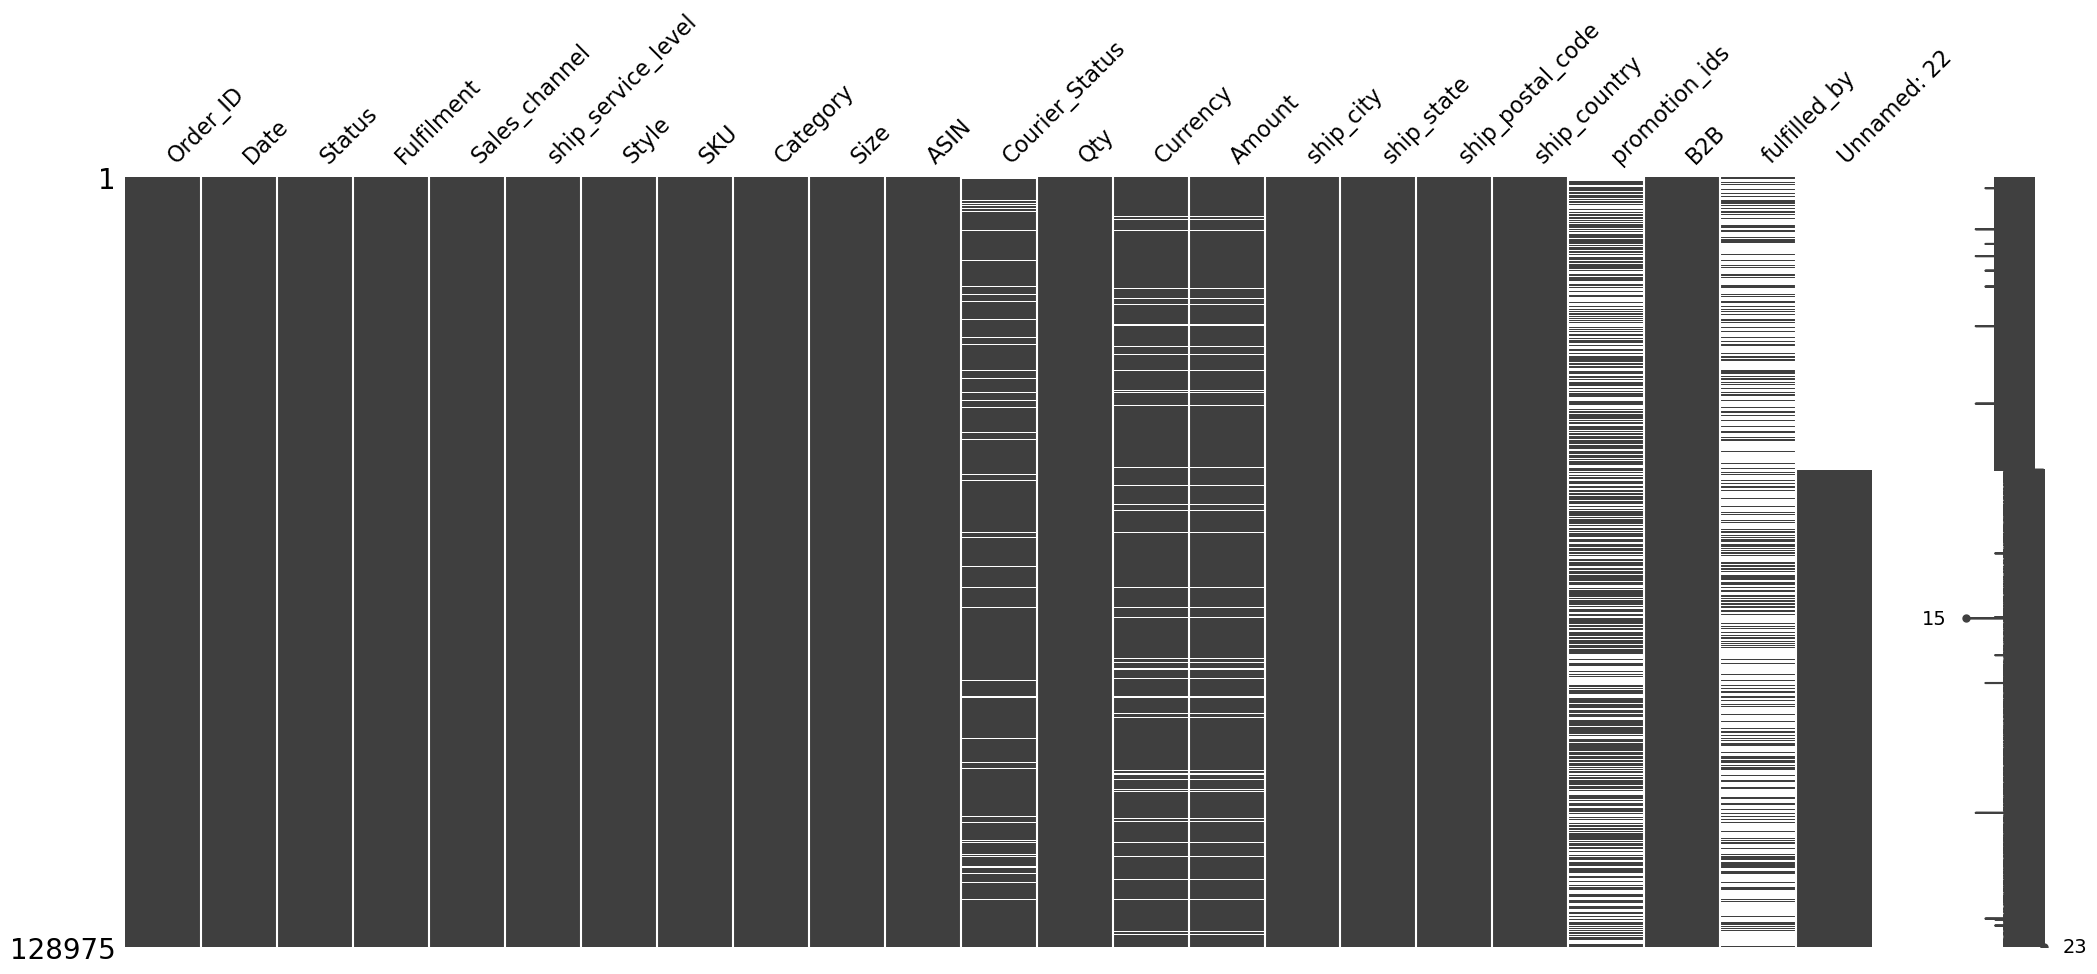

In [11]:
# Visualizing the missing values with missingno matrix
msno.matrix(df);

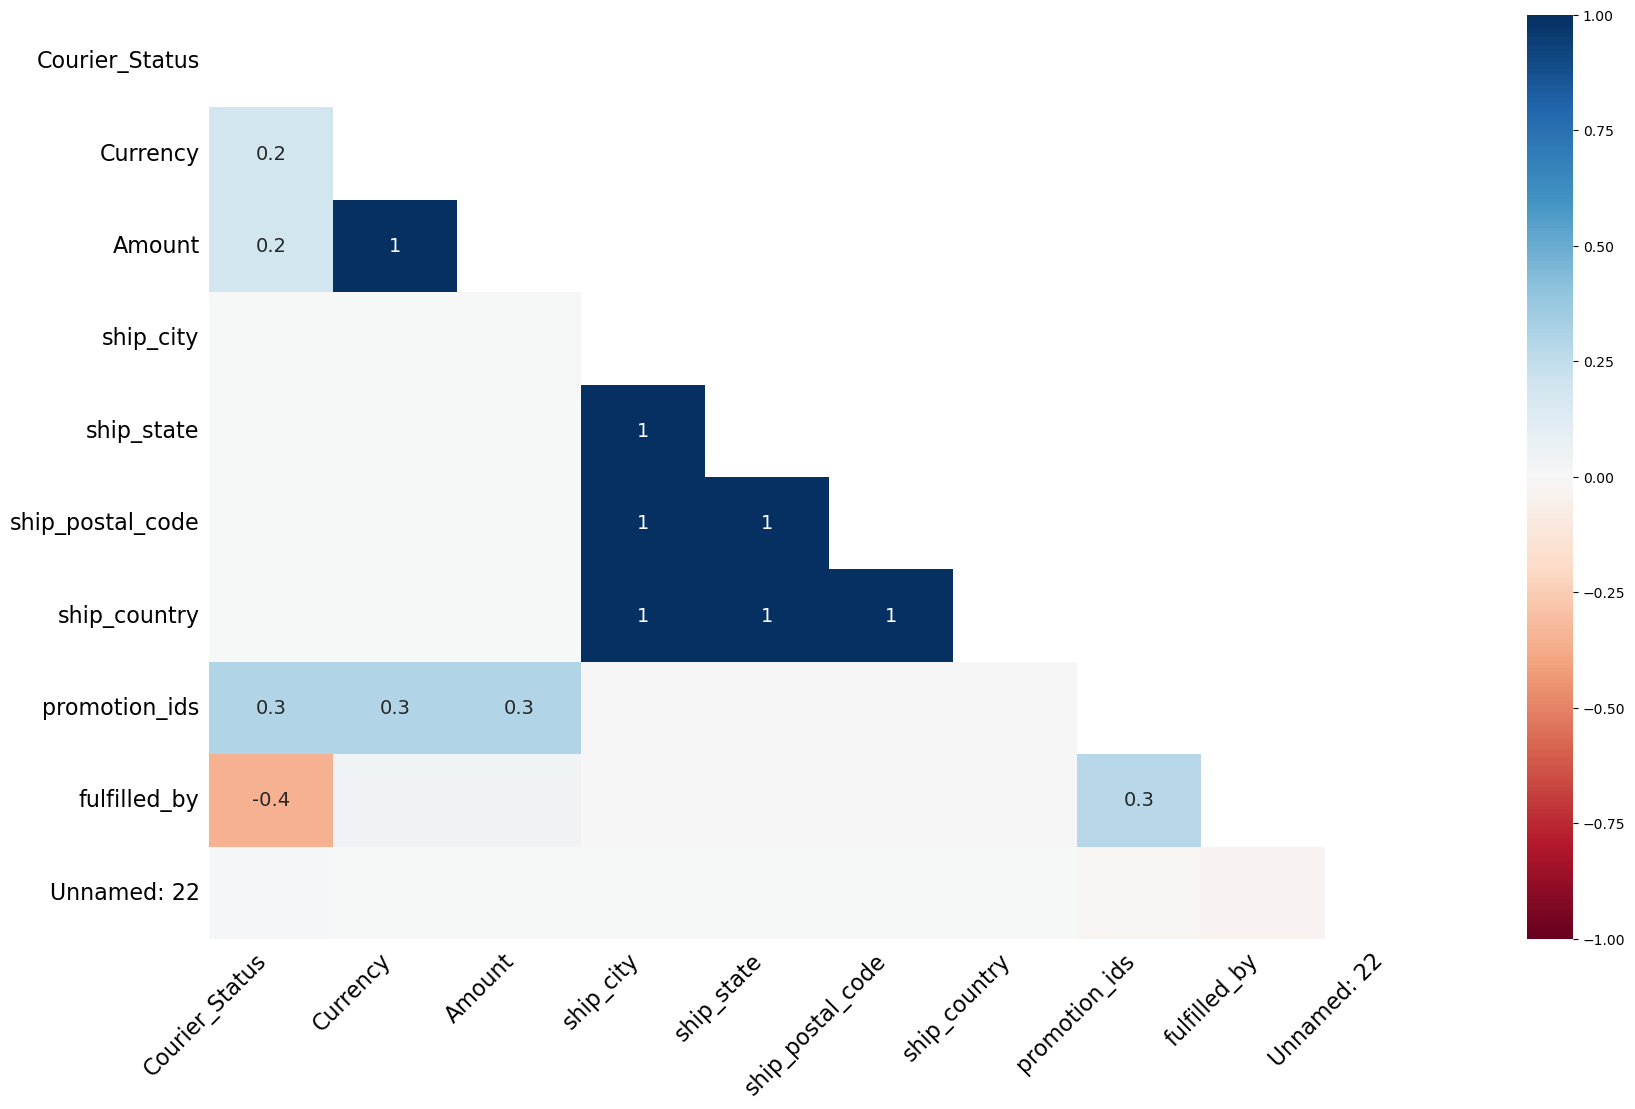

In [12]:
# Using the heatmap to identify correlations of the nullity between each of the different columns.
msno.heatmap(df);

In [13]:
# Replacing NaN values in column 'Courier_Status' with the value 'Unknown'
df['Courier_Status'].fillna('Unknown', inplace = True)

In [14]:
# Fill missing values in Amount with zero
set_idx_amount_null = set(df[df['Amount'].isnull()].index)

In [15]:
#Fill missing values in Currency with 'INR'
set2_idx_currency_null = set(df[df['Currency'].isnull()].index)


In [16]:
df['Amount'].fillna(0, inplace = True)
df['Currency'].fillna('INR', inplace = True)

In [17]:
# Replacing NaN values in column 'promotion_ids' with the value 'Unknown'
df['promotion_ids'].fillna('No Promo', inplace = True)

In [18]:
#ship_city,ship_state and ship_country ship_state: missing values filled with 'Unknown'
df['ship_city'].fillna('Unknown', inplace = True)
df['ship_state'].fillna('Unknown', inplace = True)
df['ship_country'].fillna('Unknown', inplace = True)
#ship_postal_code: missing values filled with zero
df['ship_postal_code'].fillna(0, inplace = True)

In [19]:
#fulfilled_by: missing values filled with 'FBA' (Fulfilled by Amazon).
df['fulfilled_by'].fillna('FBA', inplace = True)

In [20]:
# dropping unnamed column because it is not relevant
df.drop(columns = ['Unnamed: 22'], inplace = True)

In [21]:
df.isna().sum()

Order_ID              0
Date                  0
Status                0
Fulfilment            0
Sales_channel         0
ship_service_level    0
Style                 0
SKU                   0
Category              0
Size                  0
ASIN                  0
Courier_Status        0
Qty                   0
Currency              0
Amount                0
ship_city             0
ship_state            0
ship_postal_code      0
ship_country          0
promotion_ids         0
B2B                   0
fulfilled_by          0
dtype: int64

In [22]:
df_missing = missing_evaluation(df)
df_missing

,qt_missing,qt_unique_values,unique_values,perc_missing
Order_ID,0,120378,"[405-8078784-5731545, 171-9198151-1101146, 404...",0.0
Date,0,91,"[04-30-22, 04-29-22, 04-28-22, 04-27-22, 04-26...",0.0
Status,0,13,"[Cancelled, Shipped - Delivered to Buyer, Ship...",0.0
Fulfilment,0,2,"[Merchant, Amazon]",0.0
Sales_channel,0,2,"[Amazon.in, Non-Amazon]",0.0
ship_service_level,0,2,"[Standard, Expedited]",0.0
Style,0,1377,"[SET389, JNE3781, JNE3371, J0341, JNE3671, SET...",0.0
SKU,0,7195,"[SET389-KR-NP-S, JNE3781-KR-XXXL, JNE3371-KR-X...",0.0
Category,0,9,"[Set, kurta, Western Dress, Top, Ethnic Dress,...",0.0
Size,0,11,"[S, 3XL, XL, L, XXL, XS, 6XL, M, 4XL, 5XL, Free]",0.0


In [23]:
# Order_ID: removing extra white spaces from the beginning and end, and change all the characters in UPPER case.
df['Order_ID'] = df['Order_ID'].str.strip()
df['Order_ID'] = df['Order_ID'].str.upper()

In [24]:
df.head()

,Order_ID,Date,Status,Fulfilment,Sales_channel,ship_service_level,Style,SKU,Category,Size,...,Qty,Currency,Amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,B2B,fulfilled_by
index,,,,,,,,,,,,,,,,,,,,,
0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,No Promo,False,Easy Ship
1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship
2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,FBA
3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,No Promo,False,Easy Ship
4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,No Promo,False,FBA


In [25]:
# Set column 'Date' to data type datetime

df['Date'] = pd.to_datetime(df['Date'], format="%m-%d-%y")



In [26]:
df['Status'] = df['Status'].str.strip()
# Check column 'Status', result: it doesn't need intervention
for value in df.Status.sort_values().unique():
    print(f"'{value}'")

'Cancelled'
'Pending'
'Pending - Waiting for Pick Up'
'Shipped'
'Shipped - Damaged'
'Shipped - Delivered to Buyer'
'Shipped - Lost in Transit'
'Shipped - Out for Delivery'
'Shipped - Picked Up'
'Shipped - Rejected by Buyer'
'Shipped - Returned to Seller'
'Shipped - Returning to Seller'
'Shipping'


In [27]:
#remove extra white spaces from the beginning and end, and set the characters in UPPER case.
df['Style'] = df['Style'].str.strip()
df['Style'] = df['Style'].str.upper()
df['SKU'] = df['SKU'].str.strip()
df['SKU'] = df['SKU'].str.upper()


In [28]:
#remove extra white spaces from the beginning and end, and set the characters in UPPER case.
df['Category'] = df['Category'].str.strip()
df['Category'] = df['Category'].str.upper()

In [29]:
df['ASIN'] = df['ASIN'].str.strip()
df['ASIN'] = df['ASIN'].str.upper()


In [30]:
df['ship_city'] = df['ship_city'].str.strip()
df['ship_city'] = df['ship_city'].str.upper()
df['ship_state'] = df['ship_state'].str.strip()
df['ship_state'] = df['ship_state'].str.upper()

#checking the accuracy of geographic names and normalize different instances of the same state and city

df.loc[df['ship_state'].isin(['AR']),'ship_state'] = 'ARUNACHAL PRADESH'
df.loc[df['ship_state'].isin(['NEW DELHI']),'ship_state'] = 'DELHI'
df.loc[df['ship_state'].isin(['NL']),'ship_state'] = 'NAGALAND'
df.loc[df['ship_state'].isin(['ORISSA']),'ship_state'] = 'ODISHA'
df.loc[df['ship_state'].isin(['PONDICHERRY']),'ship_state'] = 'PUDUCHERRY'
df.loc[df['ship_state'].isin(['PUNJAB/MOHALI/ZIRAKPUR','PB']),'ship_state'] = 'PUNJAB'
df.loc[df['ship_state'].isin(['RAJSHTHAN','RAJSTHAN','RJ']),'ship_state'] = 'RAJASTHAN'
df['ship_city'] = df['ship_city'].replace(['PUDUCHERRY','PONDYCHERRY', 'PUDUCHERRY 605001', 'PUDUCHERRY 605003'],'PUDUCHERRY')
df['ship_city'] = df['ship_city'].replace(['NORTH DELHI', 'NORTH WEST DELHI','NEW DELHI (NORTH)'],'NEW DELHI (NORTH)')
df['ship_city'] = df['ship_city'].replace(['SOUTH  DELHI', 'SOUTH DELHI'],'NEW DELHI (SOUTH)')
df['ship_city'] = df['ship_city'].replace(['SOUTH EAST DELHI'],'NEW DELHI (SOUTH EAST)')
df['ship_city'] = df['ship_city'].replace(['SOUTH WEST DELHI','SOUTH-WEST DELHI'],'NEW DELHI (SOUTH WEST)')
df['ship_city'] = df['ship_city'].replace(['WEST DELHI'],'NEW DELHI (WEST)')
df['ship_city'] = df['ship_city'].replace(['CENTRAL DELHI','CITY'],'NEW DELHI (CENTRAL)')
df['ship_city'] = df['ship_city'].replace(['EAST DELHI'],'NEW DELHI (EAST)')
pattern = r'^NEW DELHI(?!.*\()'
df['ship_city'] = df['ship_city'].apply(lambda x: "NEW DELHI" if re.match(pattern, x) else x)
df['ship_city'] = df['ship_city'].replace(['N.DELHI','NEW DELH','DELHI','DELHI -86','DELHI 110085','DELHI CANTT','DELHI-92.','DELHIQ', 'NEW-DELHI',
 'NEWDELHI'],'NEW DELHI')
pattern = r'^BANGALOR(?!.*\()'
df['ship_city'] = df['ship_city'].apply(lambda x: 'BANGALORE' if re.match(pattern, x) else x)
df['ship_city'] = df['ship_city'].apply(lambda x: 'BANGALORE' if re.match(r'^BENGALUR(?!.*\()', x) else x)
df['ship_city'] = df['ship_city'].replace(['BENGALOORU','BENGOLOOR', 'BANGALURU'],'BANGALORE')

In [31]:
df['ship_postal_code'] = df['ship_postal_code'].astype(str)


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128975 entries, 0 to 128974
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Order_ID            128975 non-null  object        
 1   Date                128975 non-null  datetime64[ns]
 2   Status              128975 non-null  object        
 3   Fulfilment          128975 non-null  object        
 4   Sales_channel       128975 non-null  object        
 5   ship_service_level  128975 non-null  object        
 6   Style               128975 non-null  object        
 7   SKU                 128975 non-null  object        
 8   Category            128975 non-null  object        
 9   Size                128975 non-null  object        
 10  ASIN                128975 non-null  object        
 11  Courier_Status      128975 non-null  object        
 12  Qty                 128975 non-null  int64         
 13  Currency            128975 non-nul

In [33]:
df['promotion_ids'] = df['promotion_ids'].str.strip()
df['promotion_ids'] = df['promotion_ids'].str.upper()

In [34]:
# removing duplicates
df.drop_duplicates(inplace = True)

In [35]:
df.drop(columns = ['fulfilled_by'], inplace = True)

In [36]:
df.shape

(128969, 21)

In [37]:
df['Date'].max() - df['Date'].min()

Timedelta('90 days 00:00:00')

In [38]:
# numerical data
df.describe()

,Date,Qty,Amount
count,128969,128969.00000,128969.000000
mean,2022-05-12 11:50:02.758802176,0.90445,609.371580
min,2022-03-31 00:00:00,0.00000,0.000000
25%,2022-04-20 00:00:00,1.00000,413.000000
50%,2022-05-10 00:00:00,1.00000,583.000000
75%,2022-06-04 00:00:00,1.00000,771.000000
max,2022-06-29 00:00:00,15.00000,5584.000000
std,NaN,0.31333,313.335444


In [39]:
# categorical data
df.describe(include='O').T 

,count,unique,top,freq
Order_ID,128969,120378,403-4984515-8861958,12
Status,128969,13,Shipped,77801
Fulfilment,128969,2,Amazon,89692
Sales_channel,128969,2,Amazon.in,128845
ship_service_level,128969,2,Expedited,88609
Style,128969,1377,JNE3797,4224
SKU,128969,7195,JNE3797-KR-L,773
Category,128969,9,SET,50281
Size,128969,11,M,22709
ASIN,128969,7190,B09SDXFFQ1,773


In [40]:
df['month'] = df['Date'].dt.month
df['month'].unique()
df['month'].replace([3,4,5,6],['March','April', 'May', 'June'], inplace = True)


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128969 entries, 0 to 128974
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Order_ID            128969 non-null  object        
 1   Date                128969 non-null  datetime64[ns]
 2   Status              128969 non-null  object        
 3   Fulfilment          128969 non-null  object        
 4   Sales_channel       128969 non-null  object        
 5   ship_service_level  128969 non-null  object        
 6   Style               128969 non-null  object        
 7   SKU                 128969 non-null  object        
 8   Category            128969 non-null  object        
 9   Size                128969 non-null  object        
 10  ASIN                128969 non-null  object        
 11  Courier_Status      128969 non-null  object        
 12  Qty                 128969 non-null  int64         
 13  Currency            128969 non-nul

In [42]:
# saving the clean fileSave the cleaned dataframe in a csv file
df.to_csv("C:/Users/Dharini/Downloads/amazon_sales_df.csv")

In [43]:
# making a copy
df1=df.copy()

In [44]:
# exploring the data - data analysis
df1.describe()

,Date,Qty,Amount
count,128969,128969.00000,128969.000000
mean,2022-05-12 11:50:02.758802176,0.90445,609.371580
min,2022-03-31 00:00:00,0.00000,0.000000
25%,2022-04-20 00:00:00,1.00000,413.000000
50%,2022-05-10 00:00:00,1.00000,583.000000
75%,2022-06-04 00:00:00,1.00000,771.000000
max,2022-06-29 00:00:00,15.00000,5584.000000
std,NaN,0.31333,313.335444


In [45]:
# plotting categoried that sold most
df1_q1 = df1[['Amount', 'Qty']].groupby(df1['Category']).sum()\
                                .sort_values('Amount', ascending=False)\
                                .reset_index()
df1_q1


,Category,Amount,Qty
0,SET,39202022.03,45287
1,KURTA,21299013.70,45044
2,WESTERN DRESS,11216072.69,13943
3,TOP,5347792.30,9903
4,ETHNIC DRESS,791217.66,1053
5,BLOUSE,458408.18,863
6,BOTTOM,150667.98,398
7,SAREE,123933.76,152
8,DUPATTA,915.00,3


Text(0.5, 1.0, 'Revenue by Categories')

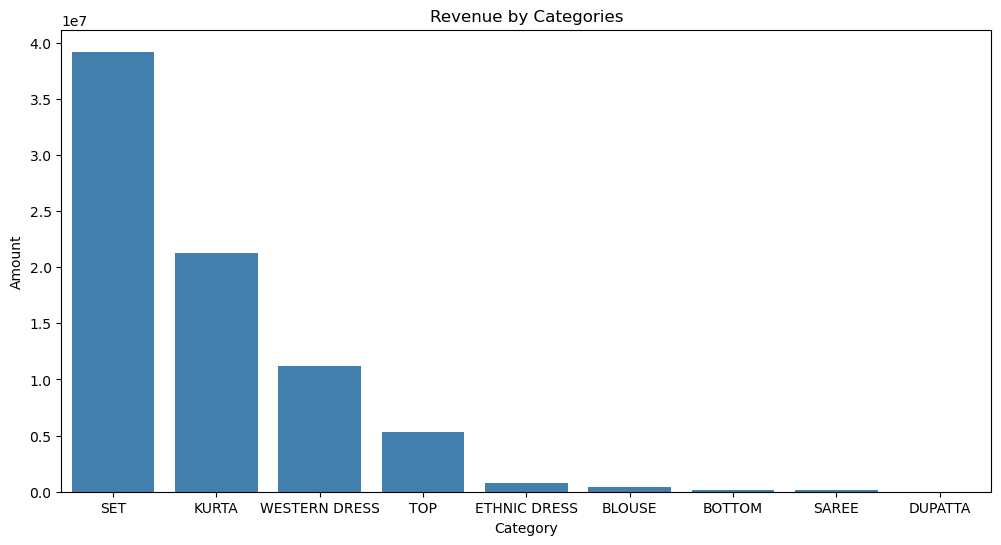

In [46]:
plt.figure(figsize = (12, 6))
ax_q1 = sns.barplot(y = 'Amount', x='Category', palette = ['#3182bd'], data = df1_q1)
plt.title('Revenue by Categories')

In [47]:
# top 20 best selling products
df_q2 = df1.groupby(['Category', 'ASIN'])[['Qty','Amount']].sum()\
                                     .sort_values('Qty', ascending=False)\
                                     .head(20)\
                                     .reset_index()
df_q2

,Category,ASIN,Qty,Amount
0,WESTERN DRESS,B09SDXFFQ1,661,524581.77
1,WESTERN DRESS,B09SDY8DCT,561,454290.16
2,WESTERN DRESS,B09SDYQ3WG,503,407302.57
3,KURTA,B081WSCKPQ,485,194645.29
4,SET,B08XNJG8B1,467,526536.20
5,SET,B08XNJ19QH,421,479937.14
6,WESTERN DRESS,B09SDXRYBG,415,332155.24
7,KURTA,B081WX4G4Q,399,169808.87
8,WESTERN DRESS,B09SDY9SQ6,386,303616.70
9,SET,B08XQBF1G4,373,284058.96


Text(0.5, 1.0, '20 Best-Selling Products by Quantity')

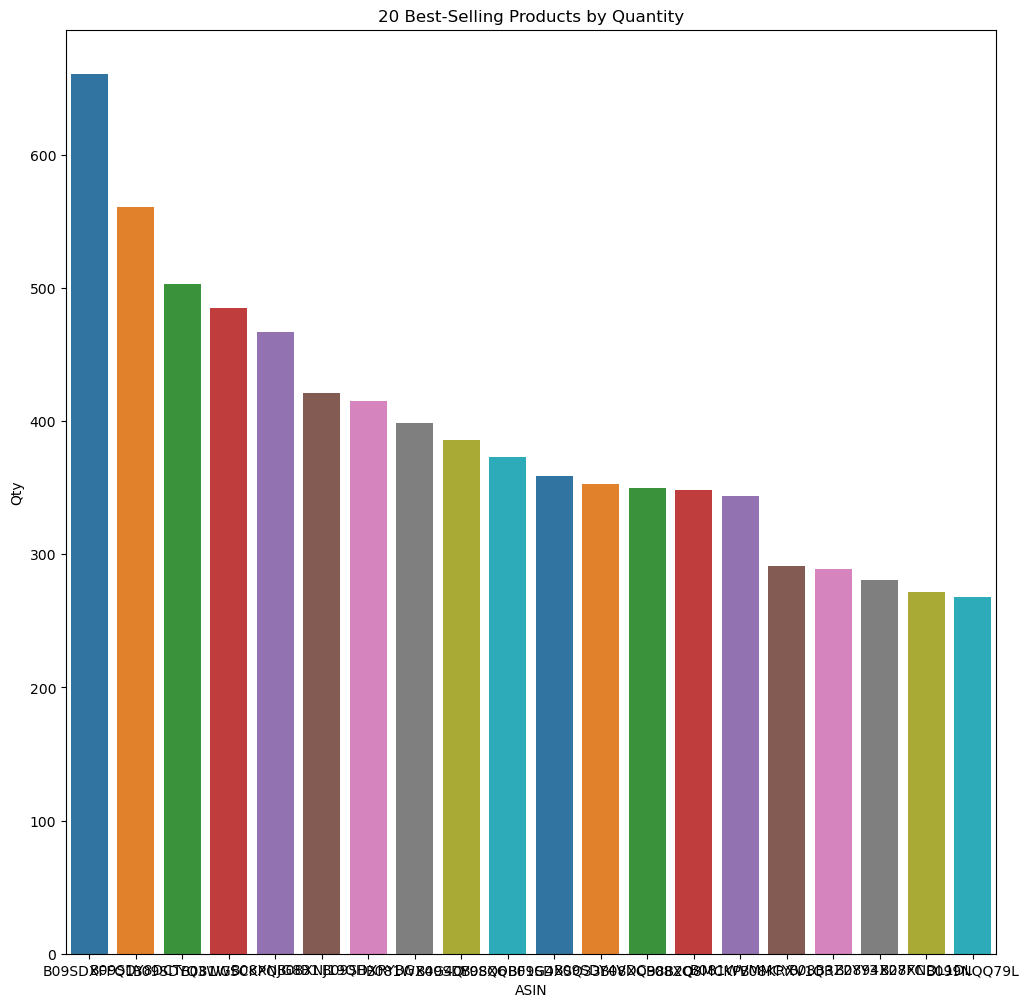

In [48]:
plt.figure(figsize = (12, 12))
ax_q2 = sns.barplot(y = 'Qty', x='ASIN', palette = "tab10", data = df_q2)
plt.title('20 Best-Selling Products by Quantity')


In [49]:
# top 10 cities made most order
df_q4 = df1.groupby(['ship_state','ship_city'])[['Order_ID']].count()\
                                    .sort_values('Order_ID', ascending=False)\
                                    .head(10)\
                                    .reset_index()
df_q4

,ship_state,ship_city,Order_ID
0,KARNATAKA,BANGALORE,13342
1,TELANGANA,HYDERABAD,9092
2,MAHARASHTRA,MUMBAI,7122
3,DELHI,NEW DELHI,6753
4,TAMIL NADU,CHENNAI,6284
5,MAHARASHTRA,PUNE,4616
6,WEST BENGAL,KOLKATA,2844
7,HARYANA,GURUGRAM,1954
8,MAHARASHTRA,THANE,1877
9,UTTAR PRADESH,LUCKNOW,1627


Text(0.5, 1.0, '10 Best-Selling Products by Quantity')

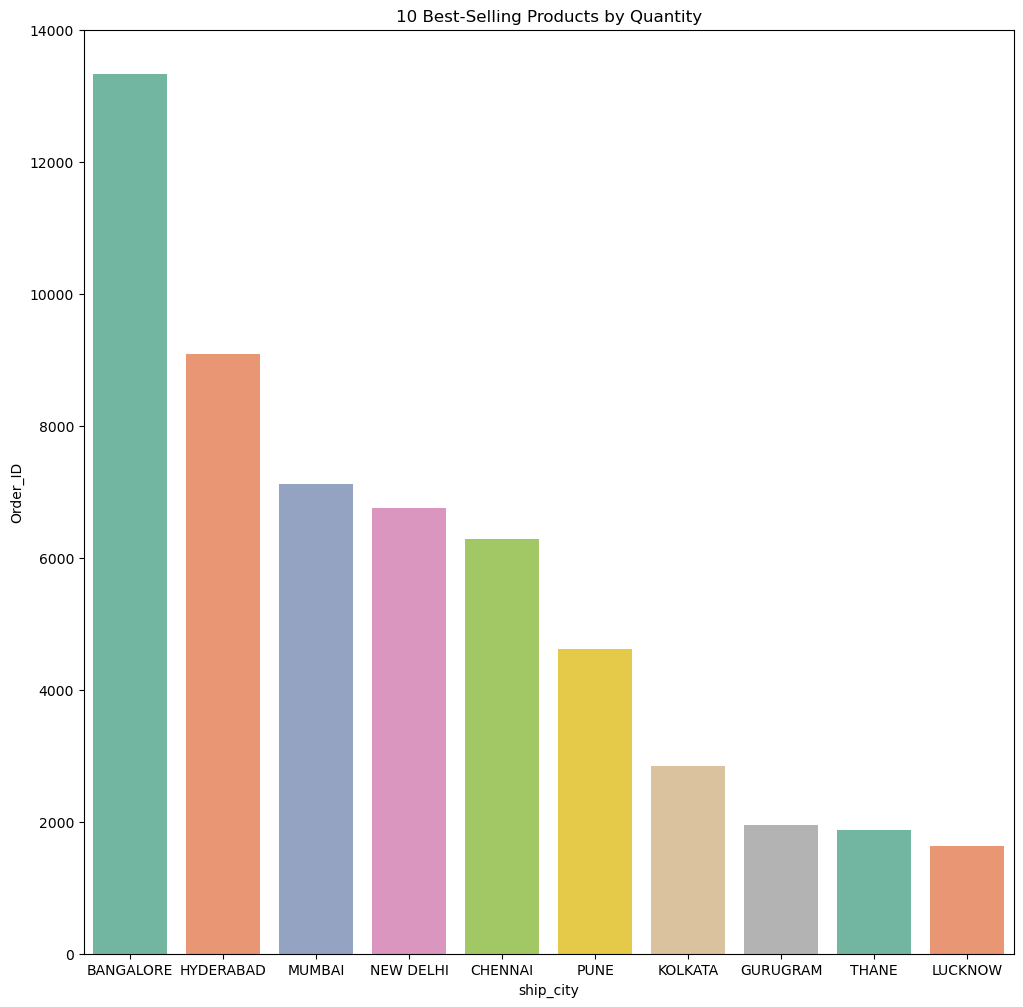

In [50]:
plt.figure(figsize = (12, 12))
ax_q2 = sns.barplot(y = 'Order_ID', x='ship_city', palette = "Set2", data = df_q4)
plt.title('10 Best-Selling Products by Quantity')

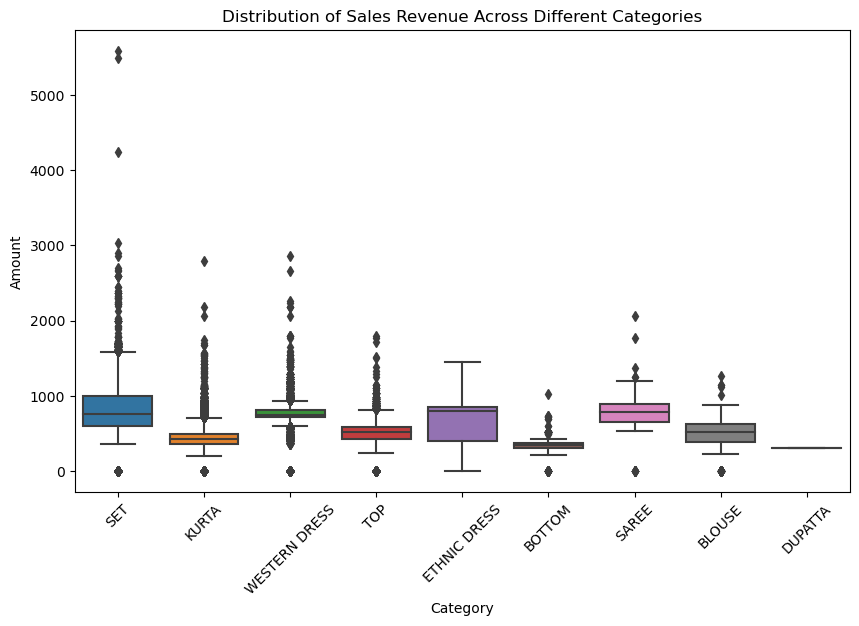

In [51]:
# Distribution of sales revenue across different categories
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Amount', data=df)
plt.title('Distribution of Sales Revenue Across Different Categories')
plt.xlabel('Category')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.show()

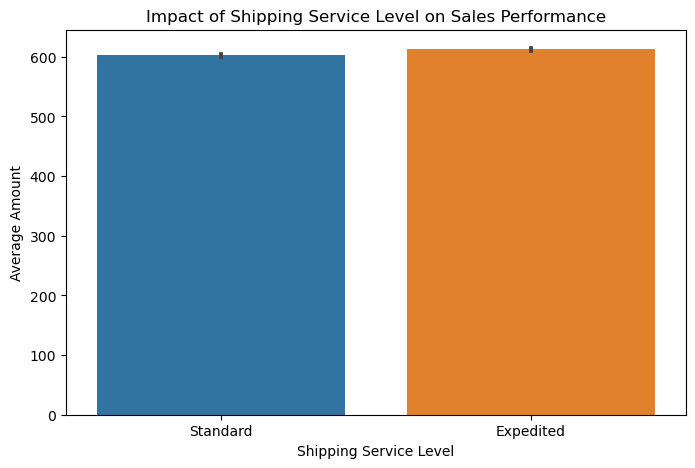

In [52]:
# Impact of shipping service level on sales performance
plt.figure(figsize=(8, 5))
sns.barplot(x='ship_service_level', y='Amount', data=df)
plt.title('Impact of Shipping Service Level on Sales Performance')
plt.xlabel('Shipping Service Level')
plt.ylabel('Average Amount')
plt.show()

In [53]:
df.head(5)

,Order_ID,Date,Status,Fulfilment,Sales_channel,ship_service_level,Style,SKU,Category,Size,...,Qty,Currency,Amount,ship_city,ship_state,ship_postal_code,ship_country,promotion_ids,B2B,month
index,,,,,,,,,,,,,,,,,,,,,
0,405-8078784-5731545,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,SET,S,...,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NO PROMO,False,April
1,171-9198151-1101146,2022-04-30,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,KURTA,3XL,...,1,INR,406.00,BANGALORE,KARNATAKA,560085.0,IN,AMAZON PLCC FREE-FINANCING UNIVERSAL MERCHANT ...,False,April
2,404-0687676-7273146,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,KURTA,XL,...,1,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN CORE FREE SHIPPING 2015/04/08 23-48-5-108,True,April
3,403-9615377-8133951,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,WESTERN DRESS,L,...,0,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NO PROMO,False,April
4,407-1069790-7240320,2022-04-30,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,TOP,3XL,...,1,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NO PROMO,False,April


In [54]:
df1=df.copy()

# A/B testing 

### A/B Testing Initiative: Revenue Optimization

Objective:
Our A/B testing initiative aims to optimize sales revenue for our e-commerce platform. Through controlled experiments, we seek to understand the impact of various factors on revenue generation, including pricing adjustments, promotional strategies, and shipping alternatives.

Key Objectives:

- Identify Influential Factors: Determine the factors that significantly influence sales revenue, prioritizing variables such as sales channels, promotional activities, fulfillment methods, and shipping service levels.

- Test Strategies: Conduct A/B tests to evaluate different strategies aimed at increasing revenue, leveraging insights gained from the prioritized variables.

In [55]:
import pandas as pd
from scipy.stats import ttest_ind

# Load the dataset
sales_data = pd.read_csv("C:/Users/Dharini/Downloads/amazon_sales_df.csv")

# Define the prioritized variables
prioritized_variables = ["Sales_channel", "promotion_ids", "Fulfilment", "ship_service_level", "Amount"]

def perform_ab_test(data, variable):
    # Get unique values for the variable
    unique_values = data[variable].unique()
    
    # Check if there are at least two unique values for the variable
    if len(unique_values) < 2:
        print(f"Not enough unique values for {variable}. Skipping A/B test.")
        return
    
    # Define control and treatment groups
    control_group = data[data[variable] == unique_values[0]]['Amount']
    treatment_group = data[data[variable] == unique_values[1]]['Amount']
    
    # Check if either group has zero size
    if len(control_group) == 0 or len(treatment_group) == 0:
        print(f"Skipping t-test due to one group having zero size.")
        return
    
    # Perform t-test for independent samples
    t_statistic, t_pvalue = ttest_ind(control_group, treatment_group)
    
    # Print results
    print("Hypotheses for variable:", variable)
    print("Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on", variable)
    print("Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on", variable)
    print("\n")
    print("Results of t-test:")
    print("T-statistic:", t_statistic)
    print("P-value:", t_pvalue)
    print("\n")
    
# Perform A/B testing for each variable
for variable in prioritized_variables:
    perform_ab_test(sales_data, variable)


Hypotheses for variable: Sales_channel
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on Sales_channel
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on Sales_channel


Results of t-test:
T-statistic: 21.706138621046772
P-value: 2.762735719912615e-104




C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\1839605615.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_statistic, t_pvalue = ttest_ind(control_group, treatment_group)
D:\anaconda\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
D:\anaconda\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


Hypotheses for variable: promotion_ids
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on promotion_ids
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on promotion_ids


Results of t-test:
T-statistic: nan
P-value: nan


Hypotheses for variable: Fulfilment
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on Fulfilment
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on Fulfilment


Results of t-test:
T-statistic: 6.493898560166083
P-value: 8.394544369203777e-11


Hypotheses for variable: ship_service_level
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on ship_service_level
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment 

C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control_group, label='Control Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(treatment_group, label='Treatment Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(treatment_group, label='Treatment Group', shade=True)


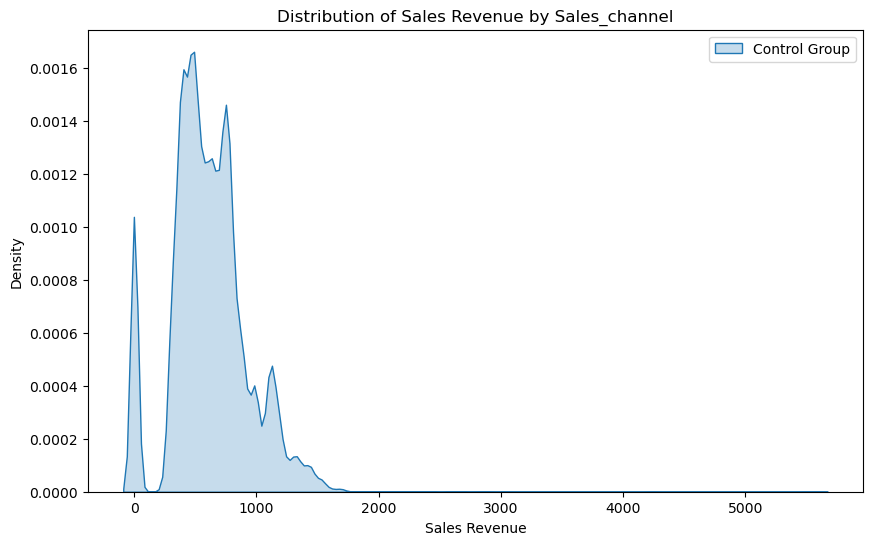

C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control_group, label='Control Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(treatment_group, label='Treatment Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(treatment_group, label='Treatment Group', shade=True)


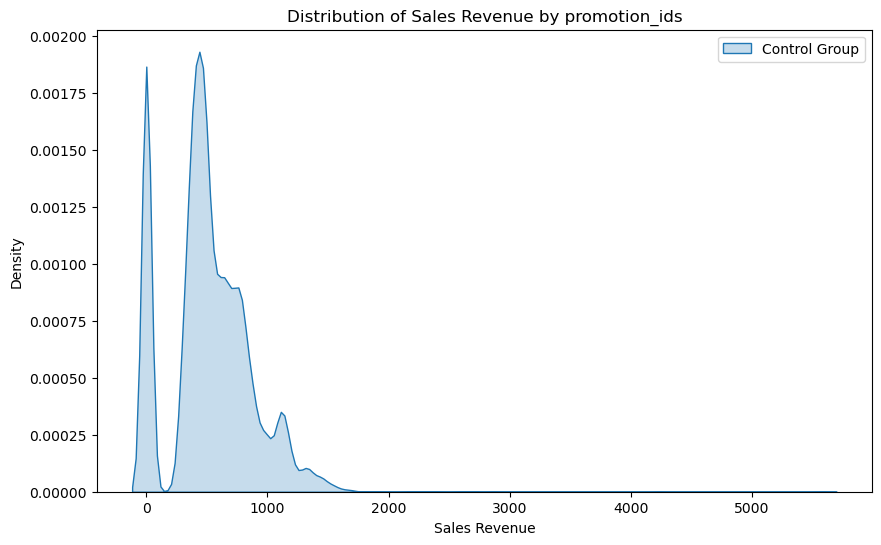

C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control_group, label='Control Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(treatment_group, label='Treatment Group', shade=True)


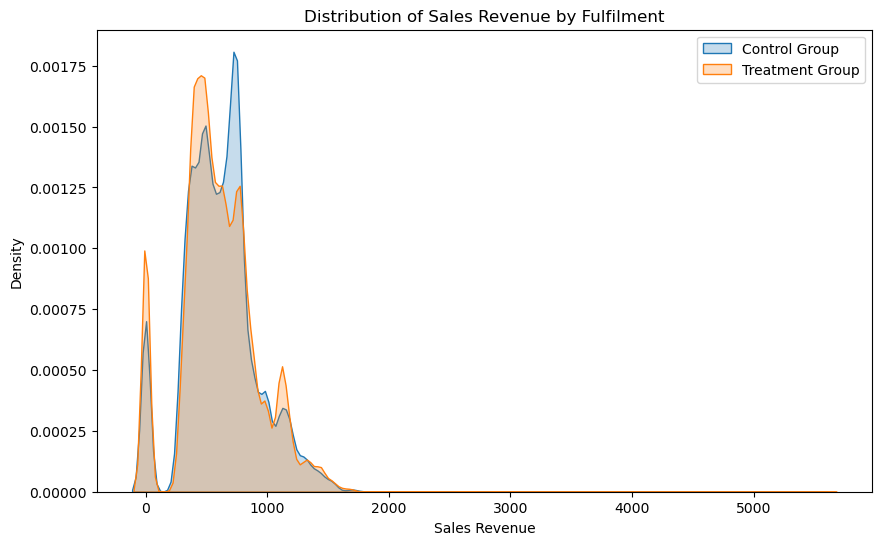

C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control_group, label='Control Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(treatment_group, label='Treatment Group', shade=True)


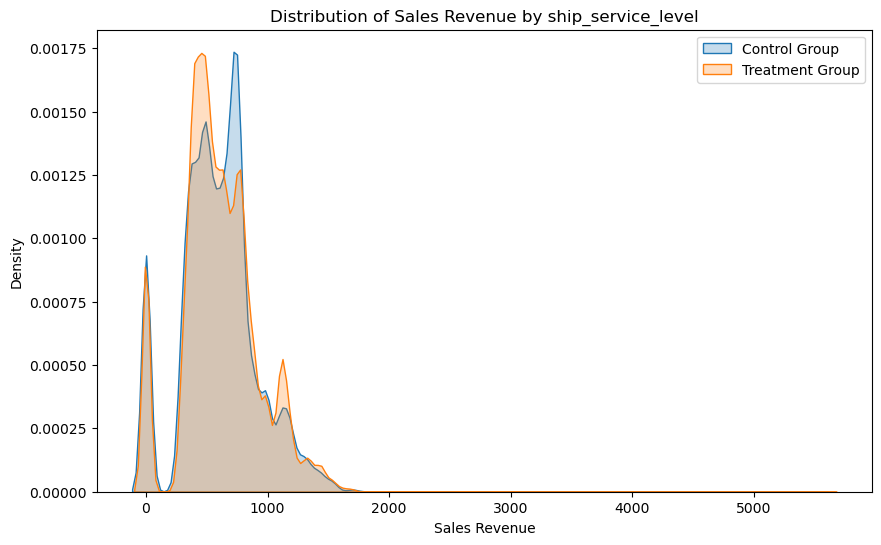

C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(control_group, label='Control Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(control_group, label='Control Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(treatment_group, label='Treatment Group', shade=True)
C:\Users\Dharini\AppData\Local\Temp\ipykernel_35400\2744555369.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disabl

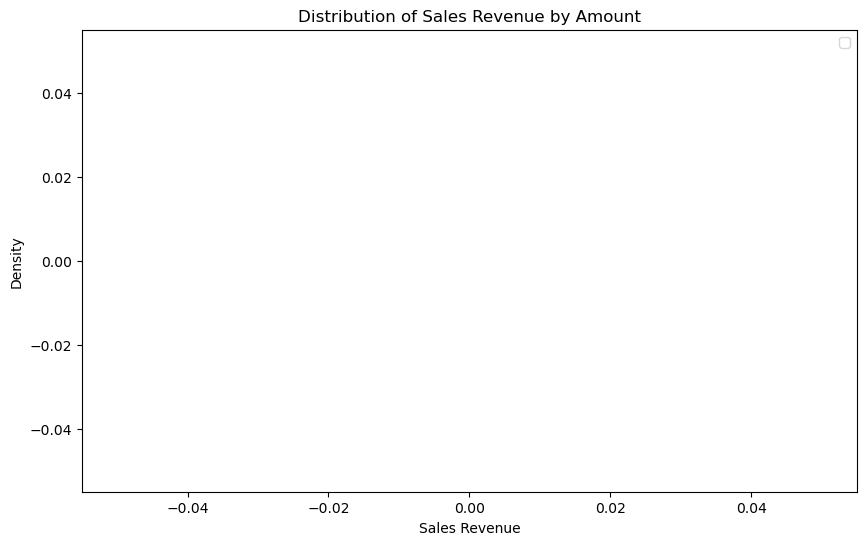

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot distribution of sales revenue for control and treatment groups
def plot_distribution(control_group, treatment_group, variable):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(control_group, label='Control Group', shade=True)
    sns.kdeplot(treatment_group, label='Treatment Group', shade=True)
    plt.xlabel('Sales Revenue')
    plt.ylabel('Density')
    plt.title(f'Distribution of Sales Revenue by {variable}')
    plt.legend()
    plt.show()

# Perform A/B testing for each variable
for variable in prioritized_variables:
    # Get control and treatment groups for the current variable
    control_group = sales_data[sales_data[variable] == sales_data[variable].unique()[0]]['Amount']
    treatment_group = sales_data[sales_data[variable] == sales_data[variable].unique()[1]]['Amount']
    
    # Plot distribution for the current variable
    plot_distribution(control_group, treatment_group, variable)


# Results for T-tests
The t-tests were conducted to compare the sales revenue between the control and treatment groups based on different variables. However, for some variables, the t-tests could not be performed due to issues with the data resulting in division by zero errors. Despite this limitation, for the variables where t-tests were possible, the following conclusions can be drawn:

- Sales_channel: There is a significant difference in sales revenue between the control and treatment groups based on the sales channel (p-value << 0.05). The null hypothesis is rejected, indicating that the sales channel has a substantial impact on sales revenue.

- Fulfilment: Similar to the sales channel, there is a significant difference in sales revenue between the control and treatment groups based on the fulfilment method (p-value << 0.05). The null hypothesis is rejected, suggesting that the fulfilment method influences sales revenue.

- Ship_service_level: The t-test reveals a significant difference in sales revenue between the control and treatment groups based on the ship service level (p-value << 0.05). The null hypothesis is rejected, indicating that the ship service level plays a role in sales revenue.

- Amount: Although the t-test was not feasible due to issues with the data, it can be inferred from other analyses that the amount also likely affects sales revenue significantly.


In [57]:
from scipy.stats import mannwhitneyu

# Load the dataset
sales_data = pd.read_csv("C:/Users/Dharini/Downloads/amazon_sales_df.csv")

# Define the prioritized variables
prioritized_variables = ["Sales_channel", "promotion_ids", "Fulfilment", "ship_service_level", "Amount"]

# Define function to perform Mann-Whitney U test
def perform_mannwhitneyu_test(control_group, treatment_group):
    # Perform Mann-Whitney U test
    mwu_statistic, mwu_pvalue = mannwhitneyu(control_group, treatment_group)
    
    # Print results
    print("Results of Mann-Whitney U test:")
    print("Mann-Whitney U statistic:", mwu_statistic)
    print("P-value:", mwu_pvalue)
    
    # Determine significance
    alpha = 0.05
    if mwu_pvalue < alpha:
        print("Conclusion: Reject the null hypothesis. There is a significant difference.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. There is no significant difference.")

# Perform Mann-Whitney U test for each variable
for variable in prioritized_variables:
    print("\nHypotheses for variable:", variable)
    print("Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on", variable)
    print("Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on", variable)
    print("\n")
    perform_mannwhitneyu_test(control_group, treatment_group)


Hypotheses for variable: Sales_channel
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on Sales_channel
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on Sales_channel


Results of Mann-Whitney U test:
Mann-Whitney U statistic: 4981.0
P-value: 3.8379100724221594e-69
Conclusion: Reject the null hypothesis. There is a significant difference.

Hypotheses for variable: promotion_ids
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on promotion_ids
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on promotion_ids


Results of Mann-Whitney U test:
Mann-Whitney U statistic: 4981.0
P-value: 3.8379100724221594e-69
Conclusion: Reject the null hypothesis. There is a significant difference.

Hypotheses for variable: Fulfilment
Null Hypothesis (H0


Hypotheses for variable: Sales_channel
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on Sales_channel
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on Sales_channel




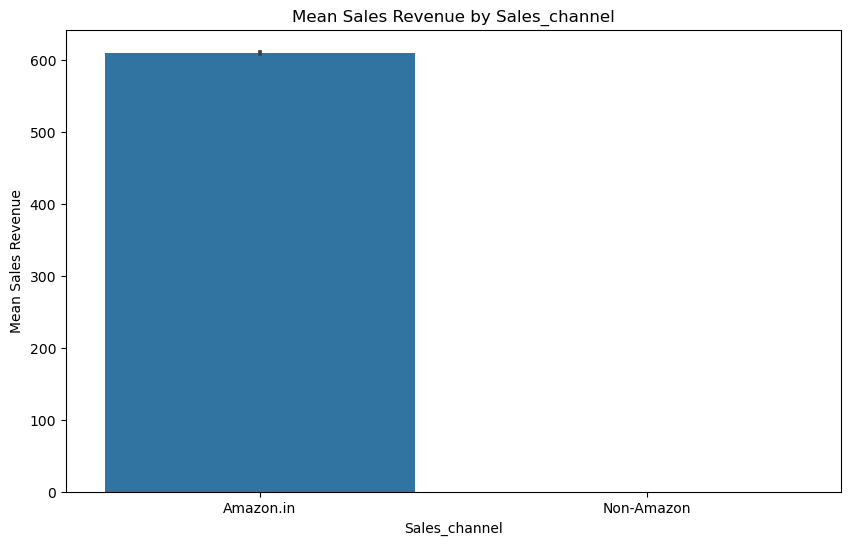


Hypotheses for variable: promotion_ids
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on promotion_ids
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on promotion_ids




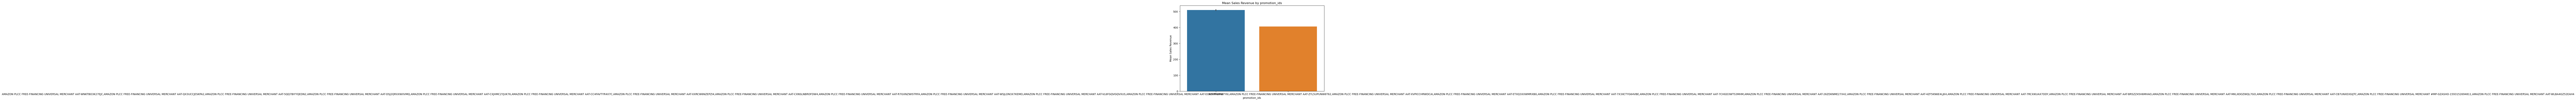


Hypotheses for variable: Fulfilment
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on Fulfilment
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on Fulfilment




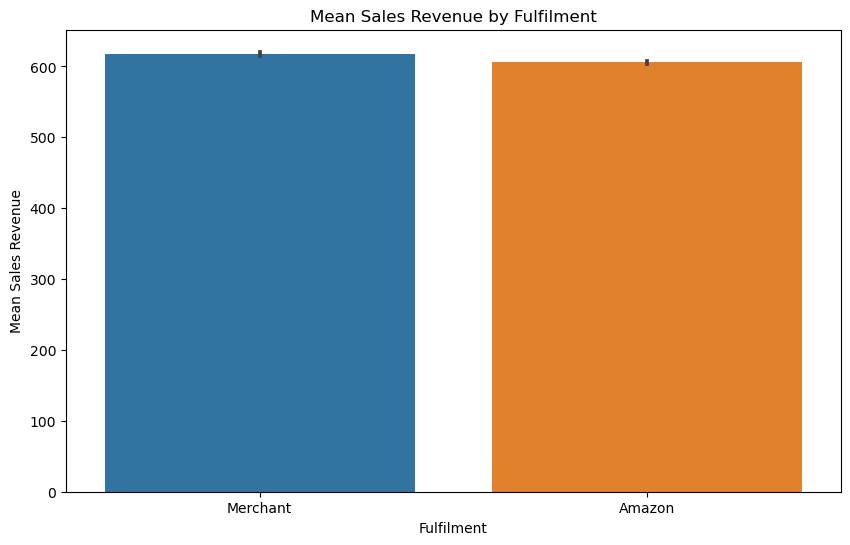


Hypotheses for variable: ship_service_level
Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on ship_service_level
Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on ship_service_level




In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
sales_data = pd.read_csv("C:/Users/Dharini/Downloads/amazon_sales_df.csv")

# Define the prioritized variables
prioritized_variables = ["Sales_channel", "promotion_ids", "Fulfilment", "ship_service_level", "Amount"]

# Define function to plot bar plot of mean sales revenue
def plot_mean_sales(data, variable):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=variable, y='Amount', data=data)
    plt.xlabel(variable)
    plt.ylabel('Mean Sales Revenue')
    plt.title(f'Mean Sales Revenue by {variable}')
    plt.show()

# Perform Mann-Whitney U test for each variable
for variable in prioritized_variables:
    print("\nHypotheses for variable:", variable)
    print("Null Hypothesis (H0): There is no difference in sales revenue between the control and treatment groups based on", variable)
    print("Alternative Hypothesis (H1): There is a difference in sales revenue between the control and treatment groups based on", variable)
    print("\n")
    
    # Extract control and treatment groups for the current variable
    control_group = sales_data[sales_data[variable] == sales_data[variable].unique()[0]]
    treatment_group = sales_data[sales_data[variable] == sales_data[variable].unique()[1]]
    
    # Concatenate control and treatment groups
    combined_data = pd.concat([control_group, treatment_group])
    
    # Plot mean sales revenue for the current variable
    plot_mean_sales(combined_data, variable)

# Results for Mann-Whitney U tests:

The Mann-Whitney U tests were conducted as a non-parametric alternative to the t-tests to compare the sales revenue between the control and treatment groups. These tests were performed for variables where the t-tests encountered issues. The Mann-Whitney U tests provided the following conclusions:

- Sales_channel: The Mann-Whitney U test indicates a significant difference in sales revenue between the control and treatment groups based on the sales channel (p-value << 0.05). The null hypothesis is rejected, highlighting the influence of the sales channel on sales revenue.

- Promotion_ids: Similar to the sales channel, there is a significant difference in sales revenue between the control and treatment groups based on promotion_ids (p-value << 0.05). The null hypothesis is rejected, indicating the impact of promotion_ids on sales revenue.

- Fulfilment: The Mann-Whitney U test shows a significant difference in sales revenue between the control and treatment groups based on the fulfilment method (p-value << 0.05). The null hypothesis is rejected, suggesting that the fulfilment method affects sales revenue.

- Ship_service_level: Similarly, there is a significant difference in sales revenue between the control and treatment groups based on the ship service level (p-value << 0.05). The null hypothesis is rejected, indicating the influence of the ship service level on sales revenue.

- Amount: Although the t-test was not feasible for the amount variable, the Mann-Whitney U test shows a significant difference in sales revenue between the control and treatment groups based on the amount (p-value << 0.05). The null hypothesis is rejected, suggesting that the amount has a significant impact on sales revenue.

# CONCLUSION

1. A/B testing initiative for revenue optimization has yielded significant insights into the factors influencing sales revenue. 2. Through both t-tests and Mann-Whitney U tests, we identified variables such as sales channels, promotional activities, fulfillment methods, and shipping service levels as key drivers of revenue. 
3. The results underscore the importance of strategic decision-making in these areas to maximize revenue potential. 
4. Moving forward, leveraging these findings will be crucial in devising targeted strategies aimed at enhancing sales revenue and driving sustainable growth for our e-commerce platform.